In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')
import pandas as pd
from google.colab import drive

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

     |████████████████████████████████| 284 kB 5.3 MB/s 
     |████████████████████████████████| 106 kB 53.7 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/CS4248/fulltrain.csv'

colnames=['Label', 'Text'] 
df = pd.read_csv(file_path, names=colnames, header=None)

df_satire = df[df["Label"] == 1]
df_reliable = df[df["Label"] == 4]

df = df_satire.append(df_reliable, ignore_index=True)
df.shape

(24042, 2)

In [ ]:
df['true_label'] = df['Label'].apply(lambda x: 0 if x == 1 else 1)
df['true_label'].value_counts()

0    14047
1     9995
Name: true_label, dtype: int64

In [ ]:
df.sample(frac=1)

,Label,Text,true_label
21245,4,Regulations mandating the treatment were well ...,1
13933,1,Sources at Cobalt Media confirmed Tuesday that...,0
10261,1,As the Feb. 20 parliamentary election approach...,0
15414,4,It may not be possible to buy love. But at lea...,1
14628,4,Al-Qaeda's number two Ayman Zawahiri called Th...,1
...,...,...,...
21575,4,National Chiao Tung University (NCTU) Presiden...,1
5390,1,"By many on-lookers and Passers-Bye, SEEN to De...",0
860,1,Saying that hell just have to put [his] head d...,0
15795,4,Iran does not oppose sending its low-enriched ...,1


In [ ]:
from sklearn.model_selection import train_test_split

X = df['Text']
y = df['true_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    # doc = strip_html_tags(doc)
    # doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    # doc = remove_accented_chars(doc)
    # doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    # doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    # doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
norm_train_reviews = pre_process_corpus(X_train.values)
norm_test_reviews = pre_process_corpus(X_test.values)

100%|██████████| 4809/4809 [00:00<00:00, 278739.24it/s]


In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('headbandand', 136448), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=136449
Number of Documents=19233


In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

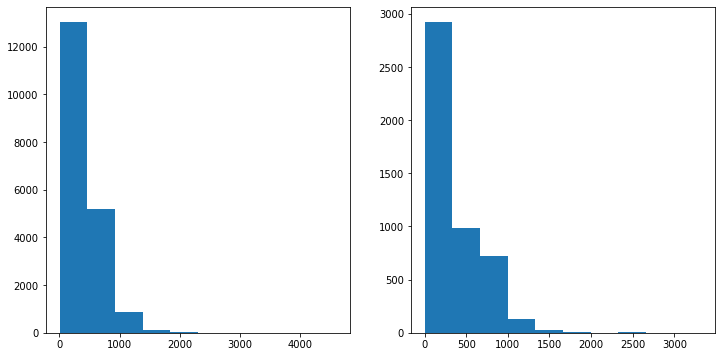

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h1 = ax[1].hist(test_lens)

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((19233, 1000), (4809, 1000))

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
EMBED_SIZE = 300
EPOCHS=3
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
# model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         40934700  
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 300)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 41,121,213
Trainable params: 41,121,213
Non-trainable params: 0
____________________________________________

In [ ]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/3
136/136 [==============================] - 606s 4s/step - loss: 0.3301 - accuracy: 0.8587 - val_loss: 0.2613 - val_accuracy: 0.9064
Epoch 2/3
136/136 [==============================] - 632s 5s/step - loss: 0.1106 - accuracy: 0.9621 - val_loss: 0.1663 - val_accuracy: 0.9589
Epoch 3/3
136/136 [==============================] - 634s 5s/step - loss: 0.0316 - accuracy: 0.9901 - val_loss: 0.1361 - val_accuracy: 0.9667


In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

151/151 [==============================] - 47s 309ms/step - loss: 0.1306 - accuracy: 0.9642
Accuracy: 96.42%


In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

In [ ]:
predictions = [1 if item == 1 else 0 for item in predictions]
predictions[:10]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['positive', 'negative']
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

In [ ]:
ssf = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for tmp_index, test_index in ssf.split(df['text'], df['label']):
    tmp_df = df[df.index.isin(tmp_index)]    
    test_df = df[df.index.isin(test_index)]

    ssf_inner = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, val_index in ssf_inner.split(tmp_df['text'], tmp_df['label']):
        train_df = df[df.index.isin(train_index)]
        val_df = df[df.index.isin(val_index)]